In [1]:
import dotenv
import pandas as pd
import matplotlib.pyplot as plt

## Pull ElectricityMaps history

In [2]:
import os
from supabase import create_client, Client
dotenv.load_dotenv()

url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [3]:
response = supabase.table("electricitymaps-hourly").select("*").eq("testing", False).execute()

In [4]:
response.data[0].keys()

dict_keys(['id', 'created_at', 'zone', 'carbon_intensity_raw', 'power_breakdown_raw', 'testing'])

In [5]:
len(response.data)

324

In [6]:
response.data[0].keys()

dict_keys(['id', 'created_at', 'zone', 'carbon_intensity_raw', 'power_breakdown_raw', 'testing'])

In [7]:
response.data[0]['carbon_intensity_raw']['history']

[{'zone': 'CA-ON',
  'datetime': '2024-08-12T04:00:00.000Z',
  'createdAt': '2024-08-09T04:54:32.766Z',
  'updatedAt': '2024-08-12T08:48:58.186Z',
  'isEstimated': True,
  'carbonIntensity': 49,
  'estimationMethod': 'TIME_SLICER_AVERAGE',
  'emissionFactorType': 'lifecycle'},
 {'zone': 'CA-ON',
  'datetime': '2024-08-12T05:00:00.000Z',
  'createdAt': '2024-08-09T05:50:06.777Z',
  'updatedAt': '2024-08-12T07:50:29.597Z',
  'isEstimated': False,
  'carbonIntensity': 44,
  'estimationMethod': None,
  'emissionFactorType': 'lifecycle'},
 {'zone': 'CA-ON',
  'datetime': '2024-08-12T06:00:00.000Z',
  'createdAt': '2024-08-09T06:49:22.181Z',
  'updatedAt': '2024-08-12T08:48:58.186Z',
  'isEstimated': False,
  'carbonIntensity': 40,
  'estimationMethod': None,
  'emissionFactorType': 'lifecycle'},
 {'zone': 'CA-ON',
  'datetime': '2024-08-12T07:00:00.000Z',
  'createdAt': '2024-08-09T07:48:50.341Z',
  'updatedAt': '2024-08-12T09:50:15.226Z',
  'isEstimated': False,
  'carbonIntensity': 42,
  

In [8]:
# Generate a big ol' dataframe by iterating over all the responses
all_records = pd.DataFrame.from_records([
    record
    for resp in response.data
    for record in resp['carbon_intensity_raw']['history']
])
all_records.loc[all_records.zone == "CA-ON"].sort_values(by='datetime', ascending=True)


,zone,datetime,createdAt,updatedAt,isEstimated,carbonIntensity,estimationMethod,emissionFactorType
0,CA-ON,2024-08-12T04:00:00.000Z,2024-08-09T04:54:32.766Z,2024-08-12T08:48:58.186Z,True,49,TIME_SLICER_AVERAGE,lifecycle
72,CA-ON,2024-08-12T05:00:00.000Z,2024-08-09T05:50:06.777Z,2024-08-12T07:50:29.597Z,False,44,None,lifecycle
1,CA-ON,2024-08-12T05:00:00.000Z,2024-08-09T05:50:06.777Z,2024-08-12T07:50:29.597Z,False,44,None,lifecycle
2,CA-ON,2024-08-12T06:00:00.000Z,2024-08-09T06:49:22.181Z,2024-08-12T08:48:58.186Z,False,40,None,lifecycle
144,CA-ON,2024-08-12T06:00:00.000Z,2024-08-09T06:49:22.181Z,2024-08-12T08:48:58.186Z,False,40,None,lifecycle
...,...,...,...,...,...,...,...,...
7654,CA-ON,2024-08-17T12:00:00.000Z,2024-08-14T12:48:24.875Z,2024-08-17T12:48:13.059Z,True,87,TIME_SLICER_AVERAGE,lifecycle
7583,CA-ON,2024-08-17T12:00:00.000Z,2024-08-14T12:48:24.875Z,2024-08-17T11:48:49.697Z,True,84,TIME_SLICER_AVERAGE,lifecycle
7655,CA-ON,2024-08-17T13:00:00.000Z,2024-08-14T13:45:14.543Z,2024-08-17T12:48:13.059Z,True,91,TIME_SLICER_AVERAGE,lifecycle
7726,CA-ON,2024-08-17T13:00:00.000Z,2024-08-14T13:45:14.543Z,2024-08-17T13:49:32.893Z,True,81,TIME_SLICER_AVERAGE,lifecycle


### EDA

In [9]:
# all_records.loc[all_records.zone == "CA-ON"].groupby("datetime").count()

In [10]:
#  all_records.loc[
#     (all_records.zone == "CA-ON") & (all_records.datetime == "2024-08-12T19:00:00.000Z")
# ]

In [11]:
# all_records.drop_duplicates().groupby(["zone", "datetime"])['carbonIntensity'].count().sort_values(ascending=False)

In [12]:
# all_records.drop_duplicates().query("zone == 'US-NE-ISNE' & datetime == '2024-08-13T05:00:00.000Z'").drop_duplicates()

In [13]:
# Within each zone,datetime group, select the record with maximum updatedAt value
idx = all_records.groupby(["zone", "datetime"])['updatedAt'].idxmax()
filtered_records = all_records.loc[idx].reset_index(drop=True)

datetime_cols = ["datetime", "createdAt", "updatedAt"]
filtered_records[datetime_cols] = filtered_records[datetime_cols].apply(pd.to_datetime).apply(lambda x: x.dt.tz_convert("America/New_York"))

In [14]:
# filtered_records.query("zone == 'US-NE-ISNE' & datetime == '2024-08-13T05:00:00.000Z'")

### Plot history

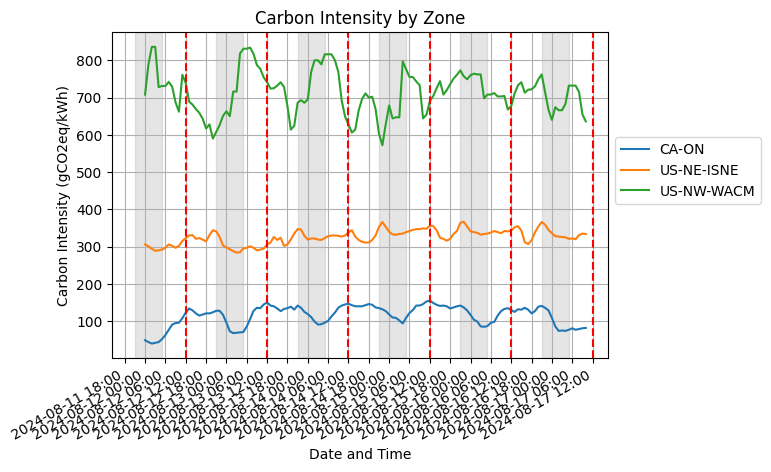

In [15]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()

for zone in filtered_records.zone.unique():
    zone_data = filtered_records.loc[filtered_records.zone == zone]
    ax.plot(zone_data.datetime, zone_data.carbonIntensity, label=zone)

# Apply gray background to nighttime hours (9 PM - 5 AM)
dates = filtered_records.datetime.dt.normalize().unique()

for date in dates:
    # Define the night interval for each date
    night_start = date + pd.Timedelta(hours=-3)  # 9 PM
    night_end = date + pd.Timedelta(hours=5)    # 5 AM next day
    noon = date + pd.Timedelta(hours=12)        # 12 PM

    # Add the shaded region directly using the localized timestamps
    ax.axvspan(night_start, night_end, color='gray', alpha=0.2)
    ax.axvline(noon, color='red', linestyle='--')

# Set major locator to every hour
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6, tz="America/New_York"))

# Set major formatter to show date and time
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M', tz="America/New_York"))

# Optional: rotate and align the tick labels so they look better
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# Optional: add grid for better readability
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 0.7))
ax.set_title("Carbon Intensity by Zone")
ax.set_ylabel("Carbon Intensity (gCO2eq/kWh)")
ax.set_xlabel("Date and Time")
fig.autofmt_xdate()
plt.show()

In [16]:
filtered_records.datetime.max().tz_convert("UTC")

Timestamp('2024-08-17 14:00:00+0000', tz='UTC')

In [21]:

filtered_records.query("zone == 'US-NE-ISNE'").shape

(131, 8)

## Retrieve overlapping carbon intensity from gridemissions API

In [22]:
from gridemissions import api

In [23]:
from gridemissions import config
config

{'DATA_PATH': PosixPath('/Users/alexhasha/data/gridemissions'),
 'TMP_PATH': PosixPath('/Users/alexhasha/tmp/gridemissions'),
 'ENV': 'PROD',
 'API_URL': 'https://api.gridemissions.com',
 'S3_URL': 'https://gridemissions.s3.us-east-2.amazonaws.com/',
 'DATA_PATH_LIVE': PosixPath('/Users/alexhasha/data/gridemissions/live')}

In [38]:
# Download overlapping CO2i emissions embodied in electricity consumption is the ISNE region
co2 = api.retrieve(
    dataset="co2",
    region=["ISNE"],
    field="D",
    start="20240719",
    end="20240721",
)

500 error: DEBUG for more info


In [37]:
co2.index.min(), co2.index.max()

(Timestamp('2024-07-20 20:00:00'), Timestamp('2024-07-21 20:00:00'))

In [41]:
df3 = pd.read_csv(
    "/Users/alexhasha/data/gridemissions/EIA_Grid_Monitor/downloads/EIA930_INTERCHANGE_2024_Jan_Jun.csv",
    parse_dates=True,
)

In [42]:
df3.head()

,Balancing Authority,Data Date,Hour Number,Directly Interconnected Balancing Authority,Interchange (MW),Local Time at End of Hour,UTC Time at End of Hour,Region,DIBA_Region
0,AECI,01/01/2024,1,MISO,74,01/01/2024 1:00:00 AM,01/01/2024 7:00:00 AM,MIDW,MIDW
1,AECI,01/01/2024,1,SPA,-233,01/01/2024 1:00:00 AM,01/01/2024 7:00:00 AM,MIDW,CENT
2,AECI,01/01/2024,1,SWPP,-87,01/01/2024 1:00:00 AM,01/01/2024 7:00:00 AM,MIDW,CENT
3,AECI,01/01/2024,1,TVA,104,01/01/2024 1:00:00 AM,01/01/2024 7:00:00 AM,MIDW,TEN
4,AECI,01/01/2024,2,MISO,173,01/01/2024 2:00:00 AM,01/01/2024 8:00:00 AM,MIDW,MIDW


In [43]:
df3["Data Date"].max()

'06/30/2024'

In [59]:
import gridemissions as ge
from gridemissions import eia_api_v2 as eia_api
from dotenv import load_dotenv
from gridemissions.workflows import make_dataset
from pathlib import Path

load_dotenv()

True

In [52]:
ge.config["EIA_API_KEY"] = os.environ.get("EIA_API_KEY")

In [53]:
df = eia_api.scrape("2024-07-01", "2024-08-16")

In [54]:
df.shape

(1105, 752)

In [57]:
df.index.min(), df.index.max()

('2024-07-01T00', '2024-08-16T00')

In [60]:
folder_out = Path("../data/processed/ge_make_dataset")
folder_out.mkdir(exist_ok=True)

In [61]:
df.to_csv("../data/processed/ge_make_dataset/data_raw.csv")

In [63]:
make_dataset(
    folder_out,
    start="2024-07-01",
    end="2024-08-16",
    scrape=False,
)

Regions for D do not match overall regions!
Regions for NG do not match overall regions!
Regions for TI do not match overall regions!
Regions for ID do not match overall regions!
Inconsistencies in trade reporting - DEBUG has missing links
/Users/alexhasha/repos/power-supply-dashboard-analysis/libs/gridemissions/src/gridemissions/clean.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2238.5 2367.5 2320.5 ... 1940.5 2141.5 2264.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.df.loc[:, data.KEY["NG"] % ba] += 0.5
/Users/alexhasha/repos/power-supply-dashboard-analysis/libs/gridemissions/src/gridemissions/clean.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2237.5 2366.5 2319.5 ... 1939.5 2140.5 2263.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

In [64]:
!ls ../data/processed/ge_make_dataset

data_basic.csv     data_deltas.csv    data_opt.csv       data_weights.csv
data_co2.csv       data_elec.csv      data_raw.csv
data_co2i.csv      data_objective.csv data_rolling.csv


In [68]:
latest_co2i = pd.read_csv("../data/processed/ge_make_dataset/data_co2i.csv", index_col=0, parse_dates=True)
latest_co2i.index.min(), latest_df.index.max()

(Timestamp('2024-07-01 00:00:00'), Timestamp('2024-08-16 00:00:00'))

In [66]:
from power_dashboard.gridemissions_utils import load_bulk

In [67]:
co2i_bulk = load_bulk("../data/interim/gridemissions", "co2i")

In [69]:
co2i_latest = ge.GraphData(latest_co2i)

In [70]:
co2i_bulk.df.index.min(), co2i_bulk.df.index.max()

(Timestamp('2018-07-01 05:00:00'), Timestamp('2024-06-15 07:00:00'))

In [86]:
co2i_latest_isne = (
    co2i_latest.df.reset_index()
    .melt(id_vars=['period'], var_name="region", value_name="CO2 Intensity")
    .query("region == 'CO2i_ISNE_D'")
    .dropna()
)
co2i_latest_isne.period = (
    co2i_latest_isne.period.dt.tz_localize("UTC") - pd.Timedelta(hours=1)
    ).dt.tz_convert("America/New_York")
co2i_latest_isne

,period,region,CO2 Intensity
62985,2024-06-30 19:00:00-04:00,CO2i_ISNE_D,272.499982
62986,2024-06-30 20:00:00-04:00,CO2i_ISNE_D,288.992090
62987,2024-06-30 21:00:00-04:00,CO2i_ISNE_D,284.879914
62988,2024-06-30 22:00:00-04:00,CO2i_ISNE_D,292.873651
62989,2024-06-30 23:00:00-04:00,CO2i_ISNE_D,294.925715
...,...,...,...
64085,2024-08-15 15:00:00-04:00,CO2i_ISNE_D,302.354640
64086,2024-08-15 16:00:00-04:00,CO2i_ISNE_D,298.919324
64087,2024-08-15 17:00:00-04:00,CO2i_ISNE_D,293.505080
64088,2024-08-15 18:00:00-04:00,CO2i_ISNE_D,298.240058


In [87]:
emaps_intensity = filtered_records.query("zone == 'US-NE-ISNE'")[["datetime", "carbonIntensity"]]
emaps_intensity

,datetime,carbonIntensity
131,2024-08-12 00:00:00-04:00,306
132,2024-08-12 01:00:00-04:00,301
133,2024-08-12 02:00:00-04:00,294
134,2024-08-12 03:00:00-04:00,289
135,2024-08-12 04:00:00-04:00,290
...,...,...
257,2024-08-17 06:00:00-04:00,322
258,2024-08-17 07:00:00-04:00,320
259,2024-08-17 08:00:00-04:00,331
260,2024-08-17 09:00:00-04:00,335


In [88]:
validation_overlap = pd.merge(co2i_latest_isne, emaps_intensity, left_on="period", right_on="datetime", how="inner")
validation_overlap

,period,region,CO2 Intensity,datetime,carbonIntensity
0,2024-08-12 00:00:00-04:00,CO2i_ISNE_D,290.206934,2024-08-12 00:00:00-04:00,306
1,2024-08-12 01:00:00-04:00,CO2i_ISNE_D,285.858167,2024-08-12 01:00:00-04:00,301
2,2024-08-12 02:00:00-04:00,CO2i_ISNE_D,281.055358,2024-08-12 02:00:00-04:00,294
3,2024-08-12 03:00:00-04:00,CO2i_ISNE_D,275.990845,2024-08-12 03:00:00-04:00,289
4,2024-08-12 04:00:00-04:00,CO2i_ISNE_D,276.200131,2024-08-12 04:00:00-04:00,290
...,...,...,...,...,...
87,2024-08-15 15:00:00-04:00,CO2i_ISNE_D,302.354640,2024-08-15 15:00:00-04:00,324
88,2024-08-15 16:00:00-04:00,CO2i_ISNE_D,298.919324,2024-08-15 16:00:00-04:00,321
89,2024-08-15 17:00:00-04:00,CO2i_ISNE_D,293.505080,2024-08-15 17:00:00-04:00,316
90,2024-08-15 18:00:00-04:00,CO2i_ISNE_D,298.240058,2024-08-15 18:00:00-04:00,321


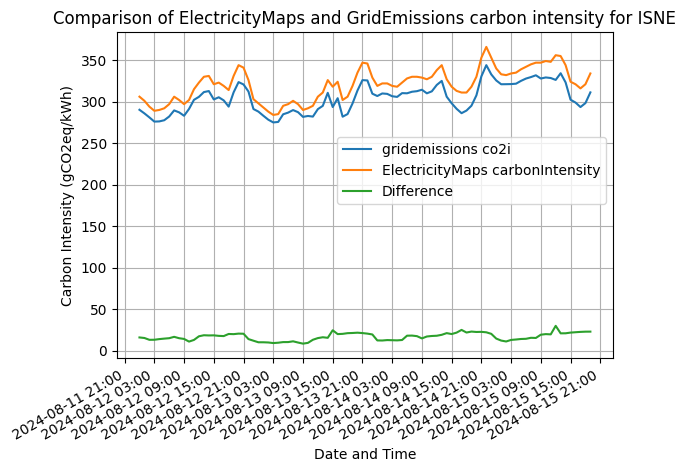

In [89]:
fig, ax = plt.subplots()
ax.plot(validation_overlap.period, validation_overlap["CO2 Intensity"], label="gridemissions co2i")
ax.plot(validation_overlap.datetime, validation_overlap.carbonIntensity, label="ElectricityMaps carbonIntensity")
ax.plot(validation_overlap.datetime, validation_overlap.carbonIntensity - validation_overlap["CO2 Intensity"], label="Difference")

# Set major locator to every hour
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6, tz="America/New_York"))

# Set major formatter to show date and time
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M', tz="America/New_York"))

# Optional: rotate and align the tick labels so they look better
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# Optional: add grid for better readability
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 0.7))
ax.set_title("Comparison of ElectricityMaps and GridEmissions carbon intensity for ISNE")
ax.set_ylabel("Carbon Intensity (gCO2eq/kWh)")
ax.set_xlabel("Date and Time")
fig.autofmt_xdate()
plt.show()

In [91]:
# The delta between the two time series is about 5% +/- 1%,
# but the intra-day max and min are consistent
delta = validation_overlap.carbonIntensity - validation_overlap["CO2 Intensity"]
mean_actual = validation_overlap.carbonIntensity.mean()
100 *delta.mean() / mean_actual, 100* delta.std() / mean_actual

(5.196158368133288, 1.404854488399104)